In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from dib_profile import DibProfile
from models import n_gaussian

In [2]:
def load_profiles(target: str):
    profiles_file = open(f'export/{target}_gaussians.csv', 'r')
    dib_profiles = []

    for profile in profiles_file.readlines():
        # Skip comments
        if profile.startswith('#'):
            continue

        _, start, end, centers, widths, amplitudes, skews, rmse, fwhm, ew = profile.split('\t')

        if ew == 0.0:
            continue

        start, end = float(start), float(end)
        centers = np.fromstring(centers.strip('[]'), sep=',')
        widths = np.fromstring(widths.strip('[]'), sep=',')
        amplitudes = np.fromstring(amplitudes.strip('[]'), sep=',')
        skews = np.fromstring(skews.strip('[]'), sep=',')

        dib_profiles.append(DibProfile(target, n_gaussian, np.column_stack((centers, widths, amplitudes, skews)).flatten(), start, end))
        
    return np.array(dib_profiles, dtype=object)

In [38]:
def synthetic_spectrum(wavelength, profiles):
    synth_spectrum = np.ones(wavelength.shape)
    centers_done = np.array([])

    for profile in profiles:
        profile_mask = (profile.start - 3 < wavelength) & (wavelength < profile.end + 3)
        center = np.mean(np.reshape(profile.parameters, (-1, 4))[:, 0])
        pred = profile.predict(wavelength[profile_mask])

        if np.any(np.abs(centers_done - center) < 1) or len(pred) > 1 and np.min(pred) < -1:
            continue

        centers_done = np.append(centers_done, [center])
        synth_spectrum[profile_mask] += pred
    
    return synth_spectrum


In [39]:
targets = ['HD185859', 'HD147889', 'HD158926', 'HD170740']
wavelength = np.arange(4000, 10_000, 1e-2)
synthetic_spectra = np.array([synthetic_spectrum(wavelength, load_profiles(target)) for target in targets])

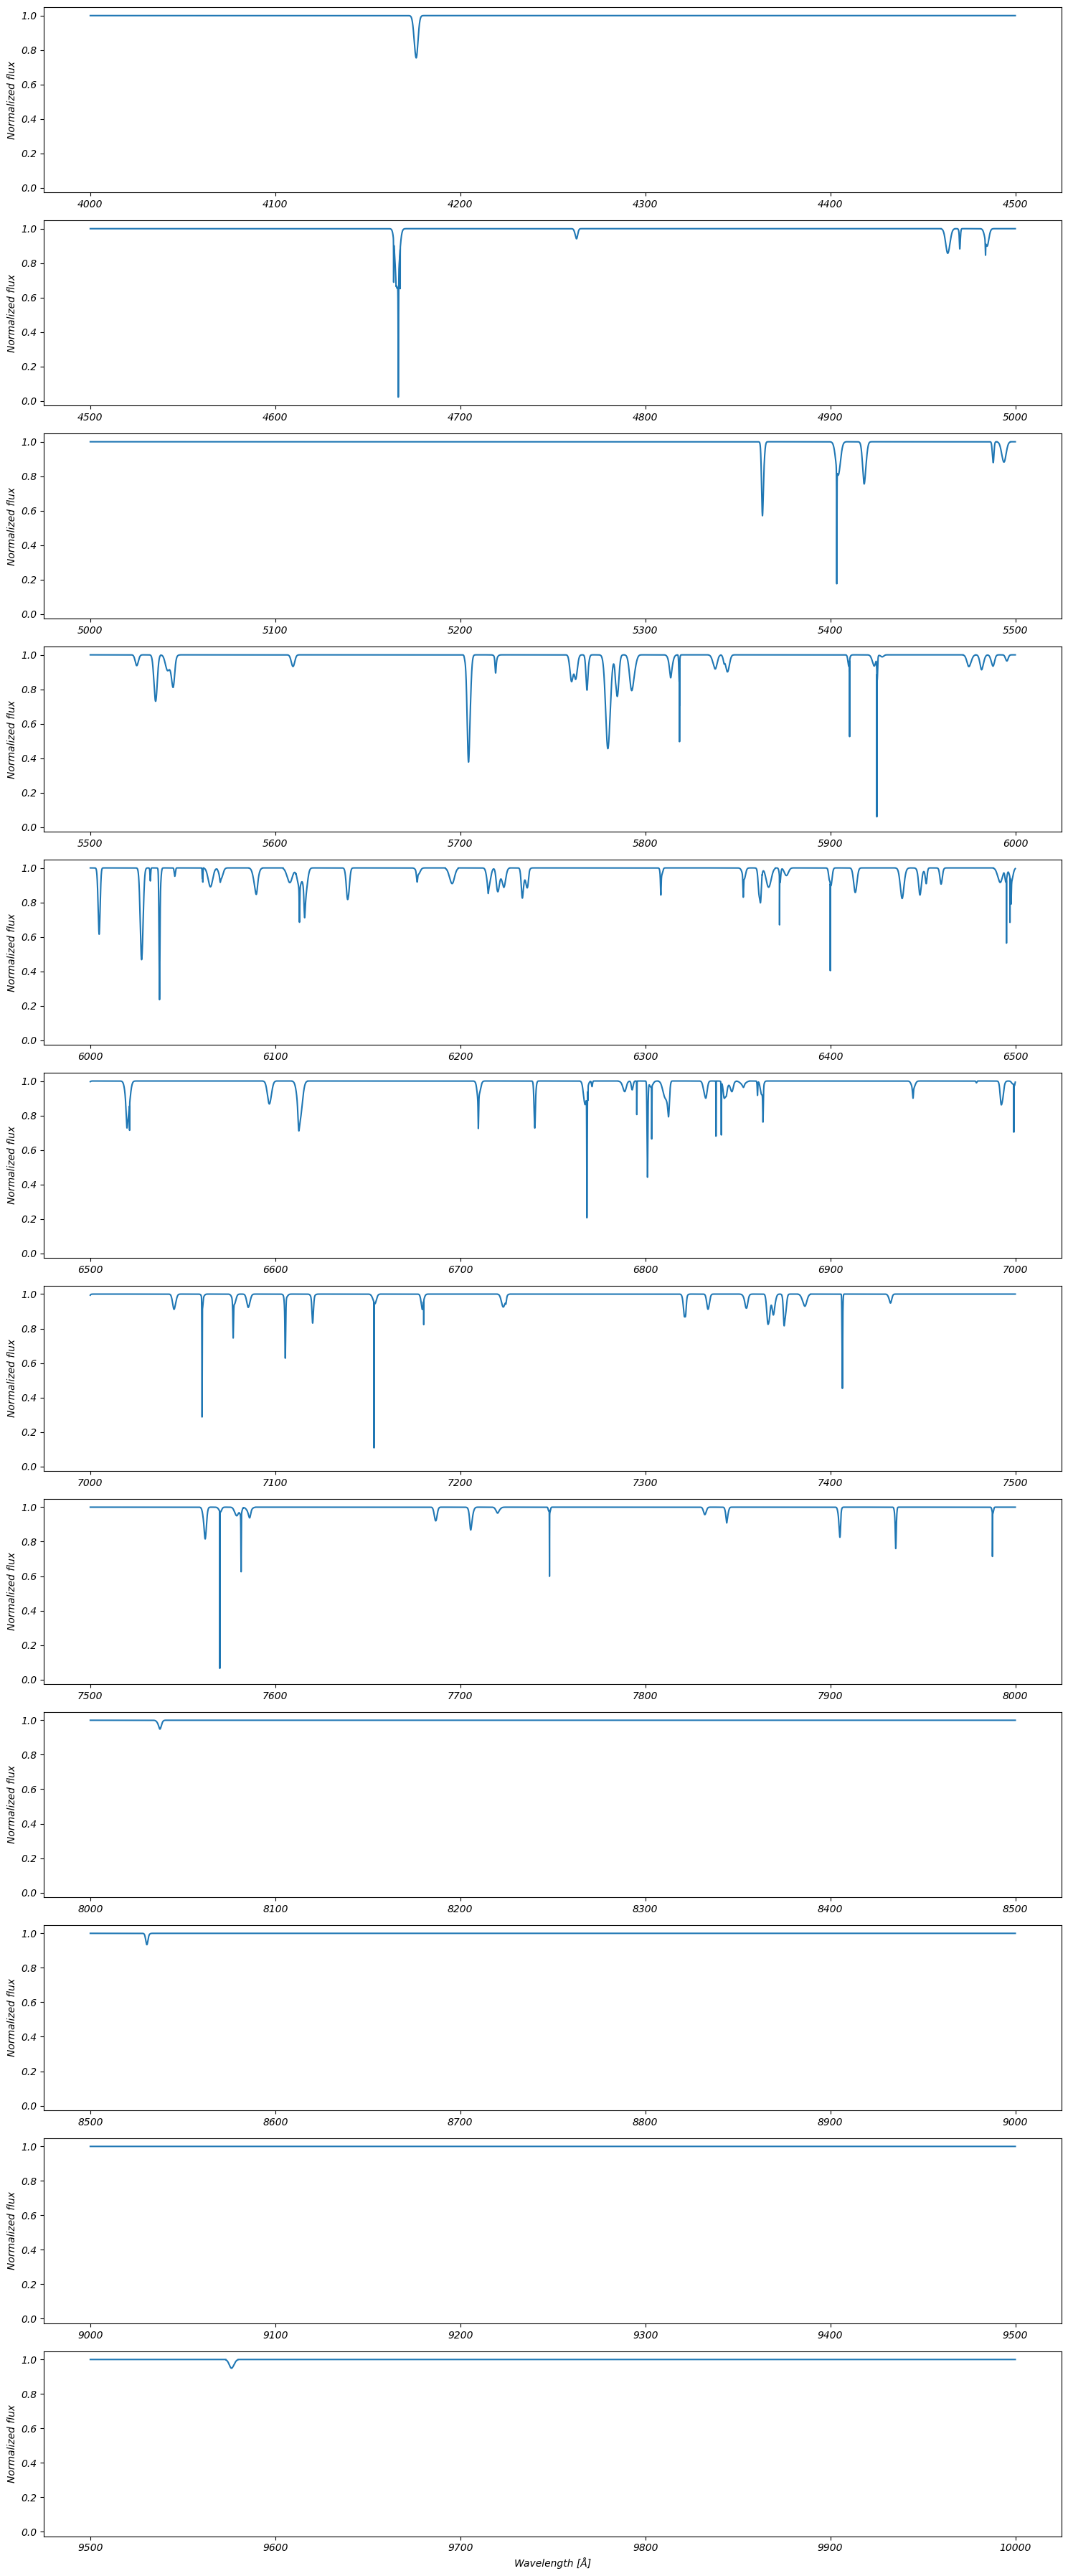

In [40]:
window_size = 500
n_plots = np.ceil((wavelength[-1] - wavelength[0]) / window_size).astype(int)

fig, axes = plt.subplots(n_plots, 1, figsize=(15, 3 * n_plots), sharey=True)

for i, ax in enumerate(axes):
    start = i * window_size + wavelength[0]
    end = start + window_size
    range_mask = (start < wavelength) & (wavelength < end)

    ax.plot(wavelength[range_mask], synthetic_spectra[0][range_mask])
    ax.set_ylabel('Normalized flux')

    # Set label on last plot
    if i + 1 == n_plots:
        ax.set_xlabel('Wavelength [Å]')

# fig.suptitle('Synthetic spectrum of HD185859')
fig.tight_layout()

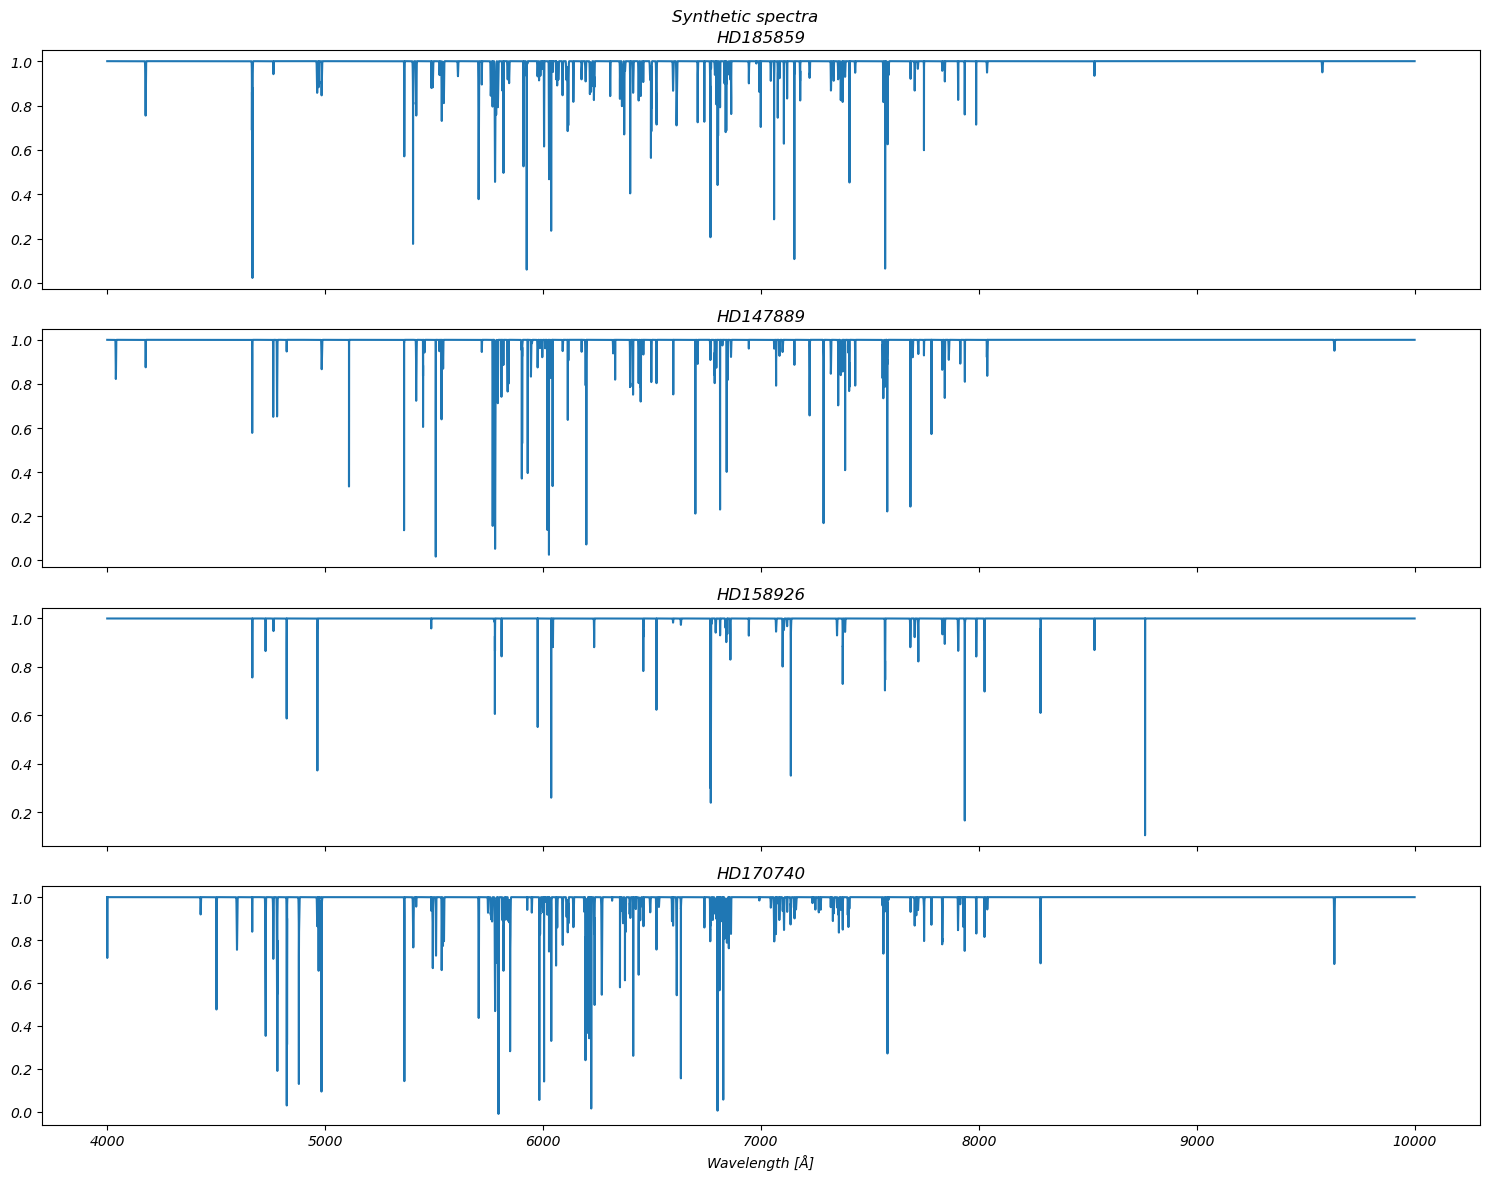

In [41]:
fig, axes = plt.subplots(len(targets), 1, figsize=(15, len(targets) * 3), sharex=True)

for synth_spec, target, ax in zip(synthetic_spectra, targets, axes.flatten()):
    ax.plot(wavelength, synth_spec)
    ax.set_title(target)

axes[-1].set_xlabel('Wavelength [Å]')
fig.suptitle('Synthetic spectra')
fig.tight_layout()

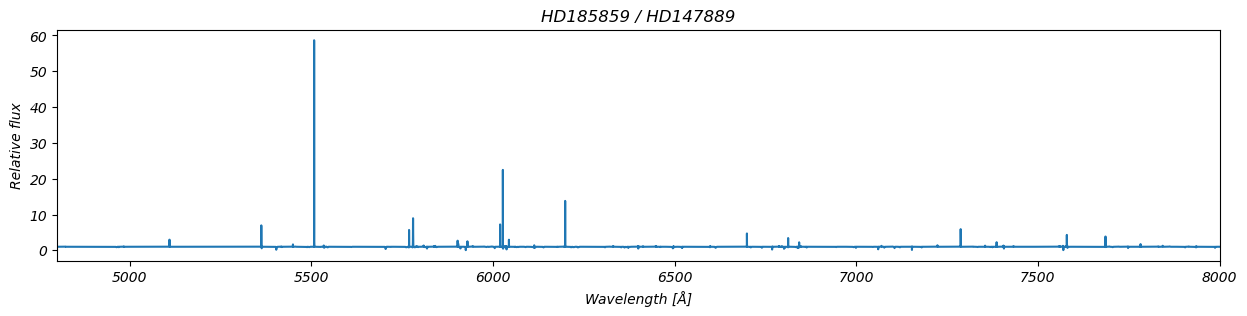

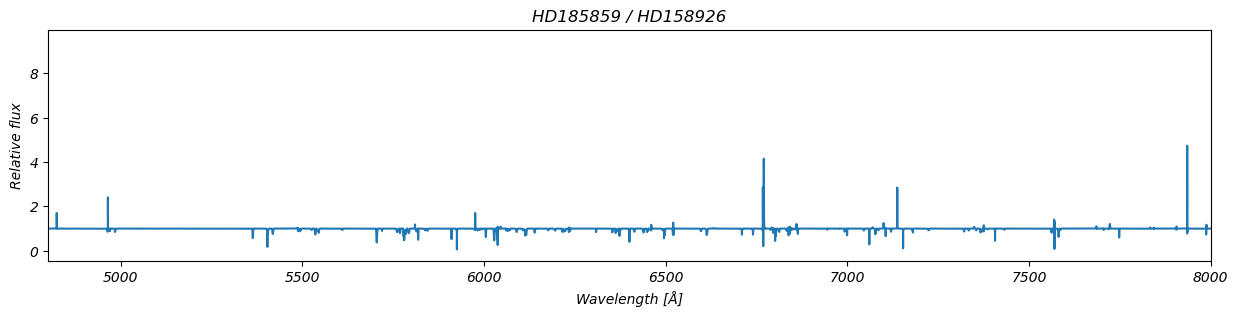

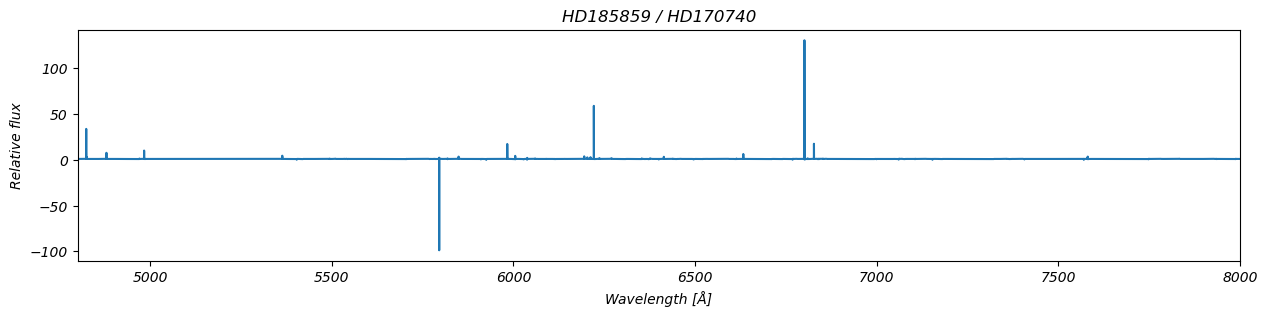

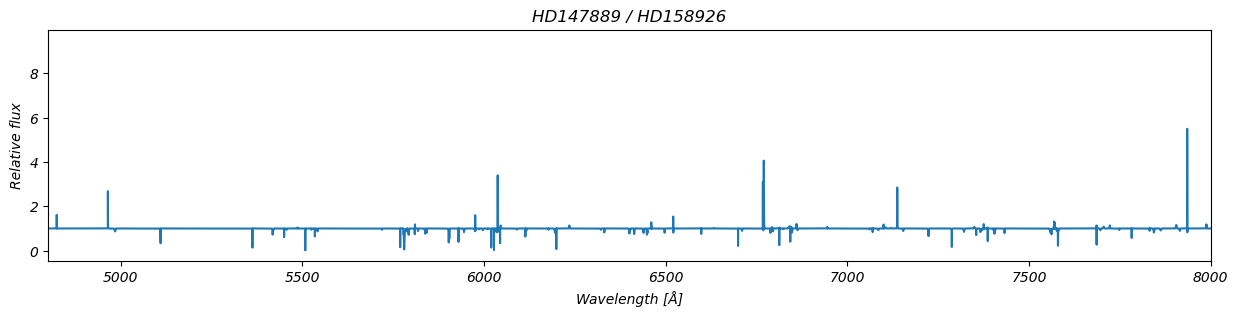

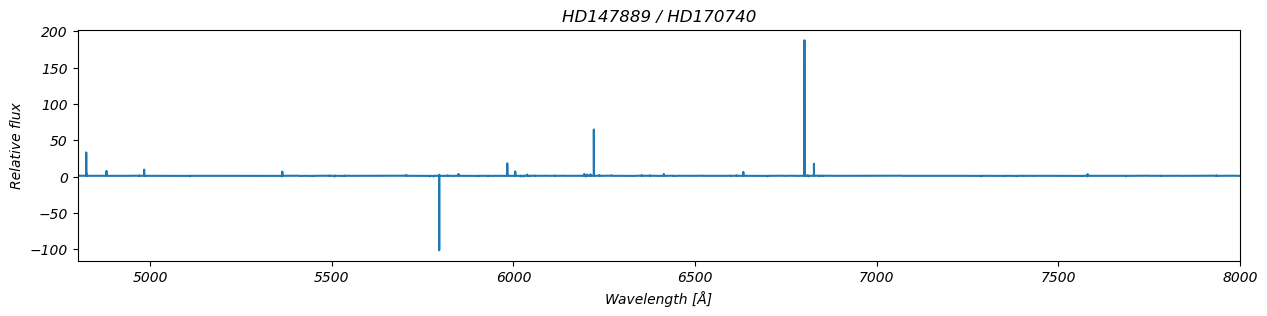

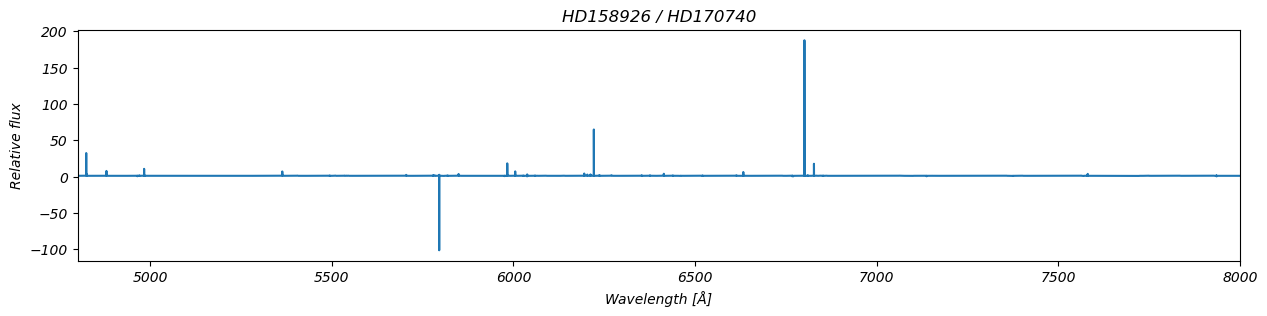

In [42]:
import itertools

for idx1, idx2 in itertools.combinations(range(len(synthetic_spectra)), 2):
    fig, ax = plt.subplots(1, 1, figsize=(15, 3))
    ax.plot(wavelength, synthetic_spectra[idx1] / synthetic_spectra[idx2])
    ax.set_title(f'{targets[idx1]} / {targets[idx2]}')
    ax.set_xlabel('Wavelength [Å]')
    ax.set_ylabel('Relative flux')
    ax.set_xlim(4800, 8000)
        